# grappa seminar week 2 : J factor

### Mathijs Laan, Pepijn Clarijn, Kerwin Buysman, Harm van Leijen

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import pandas as pd
from sympy.solvers import solve
from sympy import Symbol
import scipy.integrate as integrate
import warnings
warnings.filterwarnings('ignore')


### Here we will define some units
Gev = 1.
g = 5.62 * 10**23
kg = 1000 * g
M_s = 1.9891 * 10**30 * kg

cm = 1.
pc = 3.08 * 10**18 * cm
kpc = 1000 * pc

sec = 1.
year = 365 *24*3600 * sec


### constants
G = 6.708 * 10**-39                     # Gravitational constant
pi = math.pi
t_h = 13.6 * 10**9 * year                 # age of the universe 
H_0 = 1. /  (t_h)                         # Hubble constant
c_vir = 10.                               # virial concentration
M_mw = 10**12 * M_s                       # Mass of the milky way
rho_c = 1.9*10**-29  * g                  # The critical density of the universe
Omega_m = 0.32
r_0 = 8.25 * kpc

### The overdensity of virialized halos compared with background
Delta_vir = 18*pi**2 + 82*(Omega_m - 1) - 39*(Omega_m-1)**2



First we want to calculate some neccesary properties:

$r_{vir} = (\frac{3M}{4 \pi \Delta_{vir}\rho_{c}})^{1/3}$ , $r_{s} = \frac{r_{vir}}{c_vir}$ and $\rho_{s} = \frac{M}{4 \pi r_{s}^{s} [ln(1+c_{vir}) - c_{vir}/(1+ c_{vir})]}$

where $r_{vir}$ is the virial radius, $r_{s}$ is the scale radius and $\rho_{s}$ is the characteristic density

In [2]:
def r_vir (M):
    return (3*M / (4* pi * Delta_vir * rho_c))**(1/3)

def r_s(M):
    return r_vir(M)/c_vir
    
def rho_s(M):
    one = 4 * pi* r_s(M)**3 
    two = (math.log(1 + c_vir) -c_vir / (1 + c_vir))
    return M / (one*two)


print ("The value of  r_s = ", round(r_s(M_mw) /kpc,3), 'kpc')

print ("The value of  rho_s = ", round(rho_s(M_mw),3), 'GeV cm^-3')

The value of  r_s =  20.195 kpc
The value of  rho_s =  0.248 GeV cm^-3


For the density profile of dark matter we will use the Navarro-Frenk-White (NFW) profile:

$\rho_{NFW} = \frac{\rho_{s}}{(r/r_{s})(r/r_{s}+1)^{2}}$

where $r_{s}$ is the scale radius. If we plot this we get:

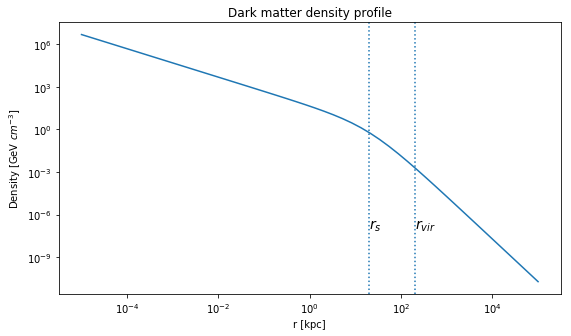

In [3]:
def NFW_profile(r, M_mw):
    ### Function for the dark matter profile ###
    rho_0 = 2.3
    return rho_0/((r/r_s(M_mw))*(r/r_s(M_mw) + 1)**2)

def DM_profile(r):
    alpha = 1
    beta = 3
    gamma = 1
    rho_0 = 2.3
    rho = rho_0* (r/r_0)** -gamma * ((1+(r_0/r_s(M_mw))**alpha)/(1+ (r/r_s(M_mw))**alpha))**((beta-gamma)/alpha)
    return rho



r_list = np.logspace(-5,5,50)
rho_list = []
rho2_list = []



for r_kpc in r_list:
    r = r_kpc * kpc
    density = NFW_profile(r, M_mw) * Gev
    density2 = DM_profile(r) * Gev
    rho_list.append(density)
    rho2_list.append(density2)
    
    
    
plt.figure(figsize=(9,5))
plt.plot(r_list,rho_list)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"r [kpc]")
plt.ylabel(r"Density [GeV $cm^{-3}}$]")
plt.title('Dark matter density profile')
plt.axvline(r_s(M_mw) / kpc, linestyle = ':')
plt.axvline(r_vir(M_mw) / kpc, linestyle = ':')
plt.text(r_s(M_mw) / kpc,  10**-7,'$r_{s}$', fontsize = 14 )
plt.text(r_vir(M_mw) / kpc,  10**-7,'$r_{vir}$', fontsize = 14 )
plt.show()




Now we want to estimate the flux of dark matter annihilations. To calculate this we will determine the so-called J-factor:

$J = \int d\Omega \int dl \rho^{2}(r(l, \Omega)) $ 

First we calculate $dJ/D\Omega$: 

$\frac{dJ}{d\Omega} = \int dl \rho^{2}(r(l,\Omega))$ 

We will use the NFW profile for the density and and we will use the cosine rule to write: 

$r = \sqrt{r_{0}^{2} + l^{2} - 2 l r_{0} cos{\psi}}$

we will then intergrate the formule from $l=0$ to $l=l_{max}$ with 

$l_{max} = \sqrt{R^{2} - r_{0}^{2}sin(\psi)^{2}} +r_{0}cos(\psi)$

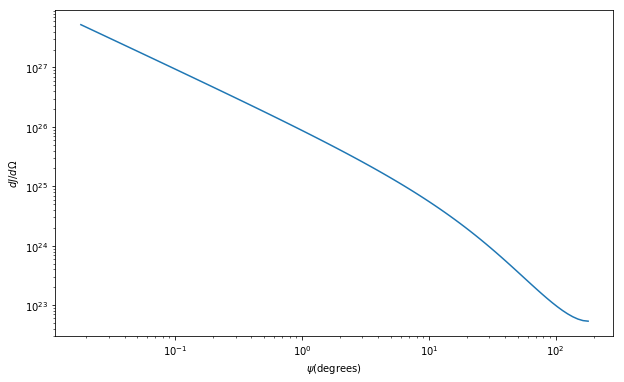

In [8]:
R = r_vir(M_mw)
r_0 = 8.25 * kpc

def l_max(psi):
    return (R**2 - r_0**2*np.sin(psi)**2)**0.5 + r_0 * np.cos(psi)
    
def r(l, psi):
    return (r_0**2 + l**2 - 2*l*r_0*np.cos(psi))**(0.5)

def DM_profile_sq(l, psi):
    return DM_profile(r(l,psi))**2
   
    
def d_l_d_sigma(psi):
    return integrate.quad(DM_profile_sq, 0, l_max(psi) , args=(psi))[0]

angles = np.logspace(-3.5,math.log10(pi),100)
d_l_d_sigma_list = []
for angle in angles:
    d_l_d_sigma_list.append(d_l_d_sigma(angle))
    
    
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(angles * 180 / pi, d_l_d_sigma_list)
ax.set_xlabel('$\psi$(degrees)')
ax.set_ylabel('$dJ / d\Omega$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

we can now estimate J by intergrating this function to $\Omega$: $J = \int \frac{dJ}{d \Omega} d\Omega$

To do this we rewrite $d \Omega$ as $2 \pi sin(\psi)d\psi$ and integrate to $\psi$ 

In [5]:
def J_int(psi):
    return d_l_d_sigma(psi)* 2*pi * math.sin(psi)

def J_Riemann(min_psi,max_psi):
    ### Here we intergrate by using the Riemann sum
    steps = 500
    dx = (max_psi - min_psi) / steps
    psi = min_psi
    J = 0
    while psi < max_psi:
        psi += dx 
        J += J_int(psi) * dx
    return J


def J_quad(min_psi,max_psi):
    ### here we intergrate using the function intergrate.quad() ###
    return integrate.quad(J_int,min_psi,max_psi)[0]

print ("if we use the Riemann methode:")
print ('J around the Galactic center within 0.5 degrees is equal to', J_Riemann(0,0.5), "Gev^2 cm^-5")
print ("if we use quad.intergrate():")
print ('J around the Galactic center within 0.5 degrees is equal to', J_quad(10**-6,0.5), "Gev^2 cm^-5")

if we use the Riemann methode:
J around the Galactic center within 0.5 degrees is equal to 2.7818760579329875e+24 Gev^2 cm^-5
if we use quad.intergrate():
J around the Galactic center within 0.5 degrees is equal to 2.785504556911212e+24 Gev^2 cm^-5


With the quid.integrate method, we integrated from 10e-6 until 0.5 degrees. The reason is that our function has an asymptote at zero. Now we only need to show that the integration from 0 to 10e-6 is negligible.

In [6]:
list_small_orders = [10**-6,10**-7,10**-8,10**-9,10**-10,10**-11]

for i in range(len(list_small_orders)-1):
    minimum = list_small_orders[i + 1]
    maximum = list_small_orders[i]
    print ('J around the Galactic center between %0.1e and %0.1e degrees is equal to' %(minimum,maximum), J_quad(minimum,maximum))

J around the Galactic center between 1.0e-07 and 1.0e-06 degrees is equal to 385201286218783.2
J around the Galactic center between 1.0e-08 and 1.0e-07 degrees is equal to 3852012867462.176
J around the Galactic center between 1.0e-09 and 1.0e-08 degrees is equal to 38520128675.15787
J around the Galactic center between 1.0e-10 and 1.0e-09 degrees is equal to 385201286.7515788
J around the Galactic center between 1.0e-11 and 1.0e-10 degrees is equal to 3852012.867515787


From these result it is clear that it converges to zero. So the integration from 0 to 10e-6 is indeed negligible in our case.